#<b>Human action recognition (HAR)</b>
Human action recognition (HAR) has a wide range of applications, such as intelligent video surveillance and environmental home monitoring, video storage and retrieval, intel- ligent human–machine interfaces, and identity recognition. Usually, HAR is performed with videos. However, processing videos on low compute devices such as IoT edge devices can be challenging and therefore it is important to develop HAR systems that can work with still images.

## Objective
Our aim is to predict the action and action class performed by a person in an input RGB image. The dataset is small to train a deep learning model as there are less observations belonging to each of the 21 classes of ‘action’ type.

## Dataset
The modified Stanford 40 Action Dataset contains images of humans performing 21 actions from 5 action- classes. There are 3030 training images in total with 100-200 images per action. The test set contains 2100 images. 


In [ ]:
# mounting drive
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
# Extracting zip file
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DeepLearning/Assignment1/A1_data/Images.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

#Importing required libraries and reading data


In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow_addons as tfa
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
import tempfile
from keras.layers import Activation, Dense
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift
from PIL import Image
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DeepLearning/Assignment1/A1_data/S40AR_train_data.csv')

In [ ]:
data.shape

(3030, 3)

In [ ]:
data.head()

,FileName,action,action_class
0,Img_1000.jpg,walking_the_dog,Interacting_with_animal
1,Img_1001.jpg,riding_a_bike,other_activity
2,Img_1002.jpg,gardening,domestic_work
3,Img_1008.jpg,cooking,domestic_work
4,Img_1010.jpg,jumping,other_activity


#Data Pre-Processing & Exploratory Data Analysis
- In this section, Label Encoding of both the target variables has been done in order to feed it to the custom data generator.
- Barplot has been used to check the frequency of each of the classes of both the target variables.
- Pie plot has been used to visualize the distribution of all the classes for both the target variables.

In [ ]:
# Label encoding
encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
data.insert(2,'action_encoded',encoder1.fit_transform(data['action'])) 
data.insert(4,'action_class_encoded',encoder2.fit_transform(data['action_class'])) 

In [ ]:
data.head()

,FileName,action,action_encoded,action_class,action_class_encoded
0,Img_1000.jpg,walking_the_dog,18,Interacting_with_animal,0
1,Img_1001.jpg,riding_a_bike,10,other_activity,2
2,Img_1002.jpg,gardening,5,domestic_work,1
3,Img_1008.jpg,cooking,2,domestic_work,1
4,Img_1010.jpg,jumping,6,other_activity,2


In [ ]:
# Pie plot for checking distribution
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

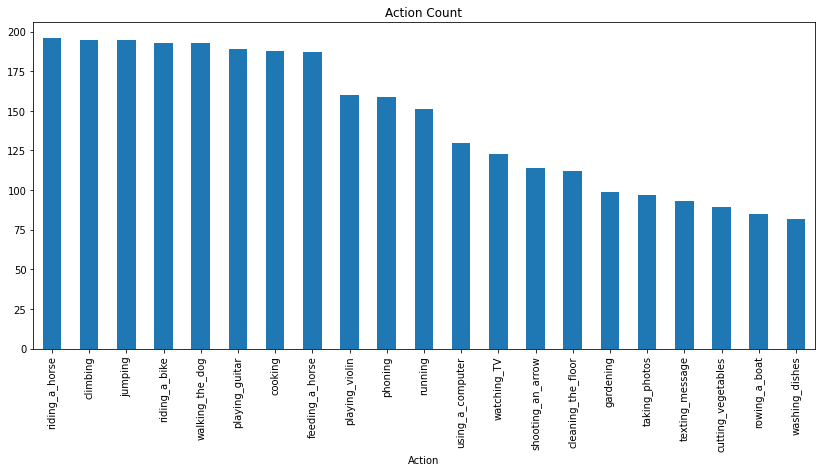

In [ ]:
# Bar plot for checking frequency of each class
plt.figure(figsize=(14,6))
ax = data.action.value_counts(normalize=False).plot.bar()
plt.xlabel('Action')
plt.title('Action Count')
plt.show()

In [ ]:
plot_distribution(data['action'])

####Observation
1. The number of unique classes for 'action' is 21 and the number of observation for each class is too low for a deep learning model.
2. Class with most observations just has around 196 observations.
3. There is huge class imbalance. The class with most number of observations i.e. 'riding_a_horse' has 2.4 times more observations than the class with least number of observations i.e. 'washing_dishes'.

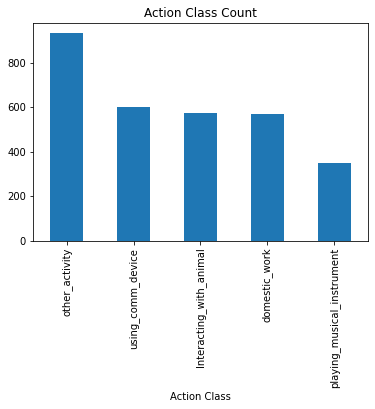

In [ ]:
plt.figure(figsize=(6,4))
ax = data.action_class.value_counts(normalize=False).plot.bar()
plt.xlabel('Action Class')
plt.title('Action Class Count')
plt.show()

In [ ]:
plot_distribution(data['action_class'])

####Observation
1. The number of unique classes for 'action_class' is 5 and the number of observation for each class is low for a deep learning model.
2. Class with most observations has around 900 observations. and the class with the lowest observation has just 349 observation
3. There is huge class imbalance in the dataset. The class with most number of observations i.e. 'other_activity' has approx 2.7 times more observations than the class with least number of observations i.e. 'playing_musical_instrument'.

#Evaluation Metric
- Macro-averaged F1 score is used in order to deal with class imbalance and give equal importance to all the classes.
- Accuracy is used to check under/over fitting.
- Confusion matrix is used to check the number of True Postives, True Negatives, False positives and False Negatives. Our aim is to find good balance of everything.
- Categorical Cross Entropy has been used as cost function because it gives a nice smooth function i.e., differentiable for gradient based optimization.

In [ ]:
# method for setting performance metric
def set_metric(output_class):
  if(output_class == 'action'):
    METRICS = [tfa.metrics.F1Score(num_classes=21,average='macro'), tf.keras.metrics.CategoricalAccuracy(name='accuracy'),]
    return METRICS

  elif(output_class == 'action_class'):
    METRICS = [tfa.metrics.F1Score(num_classes=5,average='macro'), tf.keras.metrics.CategoricalAccuracy(name='accuracy'),]
    return METRICS

In [ ]:
# method for plotting confusion matrix
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(10,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

#Function for Test Data Evaluation

In [ ]:
# method for evaluation of test data
def getResult(models):
  y_hat_all_action_class = list()
  y_hat_all_action = list()
  y_all_action = list()
  y_all_action_class = list()
  filenames = test_generator.image_ids
  N_images = len(filenames)
  batches = 0
  model = models
    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
  for x,y in test_generator:
      y_hat = model.predict(x, verbose=0)

      y_hat_action = np.argmax(y_hat[0], axis = 1)
      y_action = np.argmax(y[0], axis = 1)
      y_hat_all_action = y_hat_all_action + y_hat_action.tolist()
      y_all_action = y_all_action + y_action.tolist()

      y_hat_action_class = np.argmax(y_hat[1], axis = 1)
      y_action_class = np.argmax(y[1], axis = 1)
      y_hat_all_action_class = y_hat_all_action_class + y_hat_action_class.tolist()
      y_all_action_class = y_all_action_class + y_action_class.tolist()

      batches += 1
      if batches >= N_images / 1:
            # we need to break the loop by hand because
            # the generator loops indefinitely
          break

  result = [[y_all_action,y_hat_all_action],[y_all_action_class,y_hat_all_action_class]]
  return result

#Learning Curve Plot for Performance Visualization

In [ ]:
# method for plotting learning curve
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  plt.figure(figsize=(12,8))
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))
    c=next(cycol)
    plt.plot(x_train, y_train, label = name+'_train')
    plt.plot(x_train, y_val, label = name+'_val')

  plt.legend(loc='best')
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

#Early Stopping
Early stopping technique is used to stop the training if the validation accuracy doesn't increase for certain number of epochs and prevent our model from getting over-fitted.

In [ ]:
# early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_action_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

#Splitting Data
Random Splitting has been used with stratify set as 'action'. This helps in getting equal proportion of all the classes belonging to action variable in train, validation and test set.

In [ ]:
# stratified splitting
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42,shuffle=True, stratify= data['action'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, shuffle=True, stratify= train_data['action'])

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 1818, Val Data: 606, Test Data: 606


#Custom Data Generator and Data Augmentation
- Custom data generator has been used to get multiple outputs out of the data loader. This will help in training our model to predict both the classes at once.
- Data Augmentation has been used to reduce overfitting and increase the training image samples by rotating and shifting them.
- After every epoch, data has been shuffled so that each data point is independent and not biased by the same points before them.


In [ ]:
# custom data loader
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift, zoom
from PIL import Image
import skimage
import imgaug.augmenters as iaa
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=32, dim=(224, 224, 3), n_action= 21, n_action_class=5, data_mean=0, data_std=1,  data_prefix='', shuffle=True, Augment=True):
        
        'Initialization'
        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame
        self.dim = dim  # Dimentions of the input
        self.batch_size = batch_size

        self.indices = self.data_frame.index.tolist()

        self.n_action_class = n_action_class  # Number of classes. This is for a classification task
        self.n_action = n_action

        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch
        self.Augment = Augment  # Falg to augment the data

        self.image_label1 = data_frame['action_encoded'].values.tolist()
        self.image_label2 = data_frame['action_class_encoded'].values.tolist()

        self.image_ids = np.arange(len(self.image_label1)).tolist()

        self.data_prefix = data_prefix
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std
        
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in indexes]

        image_label_temp1 = [self.image_label1[k] for k in indexes]

        image_label_temp2 = [self.image_label2[k] for k in indexes]
        
        # Generate data
        X, y1,y2 = self.__data_generation(data_ids_temp, image_label_temp1, image_label_temp2)
        return X, [y1, y2]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    # Support function
    def __data_generation(self, data_ids_temp, image_label_temp1, image_label_temp2):
        'Generates data containing batch_size samples' 

        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y1 = np.empty((self.batch_size), dtype=int)
        y2 = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ids in enumerate(data_ids_temp):
            
            X[i,] = self.__read_data_instance(data_ids_temp[i])
            y1[i] = image_label_temp1[i]
            y2[i] = image_label_temp2[i]
        return X, keras.utils.to_categorical(y1, num_classes=self.n_action) , keras.utils.to_categorical(y2, num_classes=self.n_action_class)

    def __read_data_instance(self, pid):
      # Read an image
      filepath = self.data_prefix + self.data_frame.iloc[pid]['FileName']
      
      if(filepath == './Images/Img_3201.jpg'):
        return
      data = Image.open(filepath)
      data = data.resize((224,224))
      
      data = np.asarray(data)

      if self.Augment:
          # random rotation
          rot = np.random.rand(1) < 0.5
          if rot:
              rot = np.random.randint(-10,10, size=1)
              data = rotate(data, angle=rot[0], reshape=False)

          # shifting
          shift_val = np.random.randint(-5, high=5, size=2, dtype=int).tolist() + [0,]
          data = shift(data, shift_val, order=0, mode='constant', cval=0.0, prefilter=False)

          # cropping the image by 20%
          # crop = iaa.Crop(percent=(0, 0.2)) # crop image
          # data=crop.augment_image(data)
          
          # flipping horizontally
          flip_hr=iaa.Fliplr(p=1.0)
          data= flip_hr.augment_image(data)

      X = data
      # preprocess_input(X)

      # Input normalization
      X = (X - self.data_mean)/self.data_std
      return X

In [ ]:
data_mean = 0.
data_std = 255.0
prefix='./Images/'

training_generator = DataGenerator(train_data, batch_size=32, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix)
validation_generator = DataGenerator(val_data, batch_size=32, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix)

# Visualizing the data generator samples

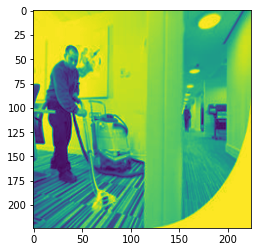

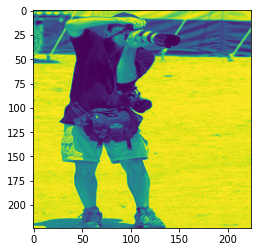

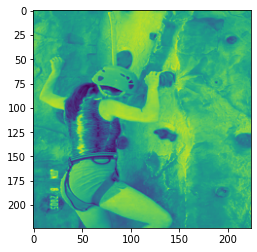

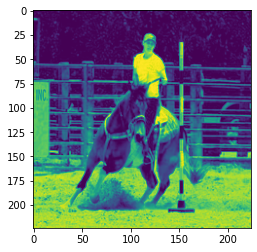

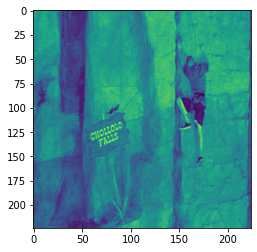

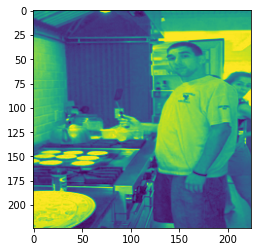

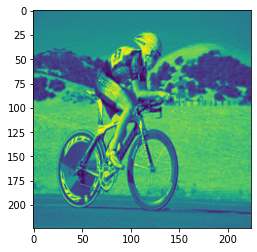

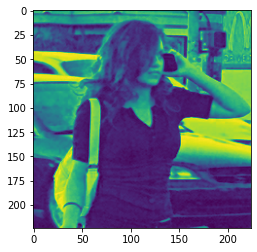

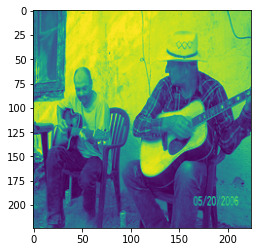

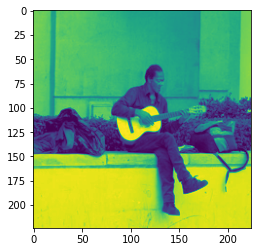

In [ ]:
i=0
for x,y in training_generator.__iter__():
  # print(x.shape, y[0].shape,y[1].shape
  if i<10:
    plt.imshow(x[0,:,:,0])
    plt.pause(.1)
    i+=1
  else:
    break

#Baseline Model
- Convolutional Neural Network is used because it works best for image classification.
- ANN is not chosen because as the number of hidden layers and hidden neurons increases, weights associated with those neurons also increases. This leads to vanishing gradient problem. Hence, feature engineering/extraction becomes important to reduce number of input parameters.
- Feature engineering is a complex task without much knowledge about the image. Hence, CNN accomplishes this task more efficiently through its convolution filters.
- In CNN, feature is extracted on its own through convolutional, max pooling layers.
- Pooling is used to reduce the dimensionality of the feature map.

#MobileNetV2 Model
- After carefully analysing different models architecture, MobileNetV2 has been shortlisted since it is very lightweight which makes the training process very fast.
- MobileNetV2 is 32 times smaller and 10 times faster than VGG 16 and it still produces equal results.
- In MobileNetV2, there are two types of blocks. One is residual block with stride of 1. Another one is block with stride of 2 for downsizing.
- There are 3 layers for both types of blocks.
- The first layer is 1×1 convolution with ReLU6.
- The second layer is the depthwise convolution.
- The third layer is another 1×1 convolution but without any non-linearity. It is claimed that if ReLU is used again, the deep networks only have the power of a linear classifier on the non-zero volume part of the output domain.
- The top layer has been removed and two output dense layer has been added.


In [ ]:
# Method to create model
def create_mobileNet_model(inp_shape, n_action, n_action_class, optimizer='adam', fine_tune=0, transfer_learning=False,drop = 0 ):
  
  conv_block = tf.keras.applications.MobileNetV2(include_top = False,input_shape = inp_shape)
  
  # checking if trasfer learning should be applied
  if transfer_learning == True:
    if fine_tune > 0:
      for layer in conv_block.layers[:-fine_tune]:
        layer.trainable = False
    else:
      for layer in conv_block.layers:
        layer.trainable = False
  
  image_batch, label_batch = next(iter(training_generator))
  feature_batch = conv_block(image_batch)

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)

  prediction_layer_action = Dense(n_action, activation='softmax', name='action')
  prediction_layer_action_class = Dense(n_action_class, activation='softmax', name='action_class')

  inputs = tf.keras.Input(shape=inp_shape)
  x = conv_block(inputs, training=False)
  x = global_average_layer(x)

  if(drop!=0):
    x = tf.keras.layers.Dropout(drop)(x)

  # adding custom dense output layers 
  output_action = prediction_layer_action(x)
  output_action_class = prediction_layer_action_class(x)

  model = tf.keras.Model(inputs, [output_action,output_action_class])

  # Compiles the model for training.
  model.compile(optimizer=optimizer, 
              loss={
                  'action': "categorical_crossentropy", 
                  'action_class': "categorical_crossentropy"},
              metrics={
                  'action': set_metric('action'),
                  'action_class': set_metric('action_class')})
    
  return model
  

In [ ]:
# Intialization of parameters
input_shape = (224, 224, 3)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
n_action = 21
n_action_class = 5

##MobileNetV2 without transfer learning

In [ ]:
# model without transfer learning
mobileNet_model1 = create_mobileNet_model(input_shape, n_action, n_action_class, optimizer, transfer_learning=False)

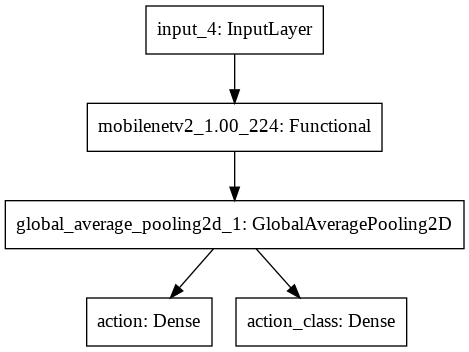

In [ ]:
tf.keras.utils.plot_model(mobileNet_model1)

In [ ]:
mobileNet_model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_4[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
action (Dense)                  (None, 21)           26901       global_average_pooling2d_1[0][0] 
____________________________________________________________________________________________

In [ ]:
# fitting model
m_histories = {}
m_histories['Without Transfer Learning'] = mobileNet_model1.fit(training_generator, epochs=50, validation_data=validation_generator, callbacks= [early_stopping])

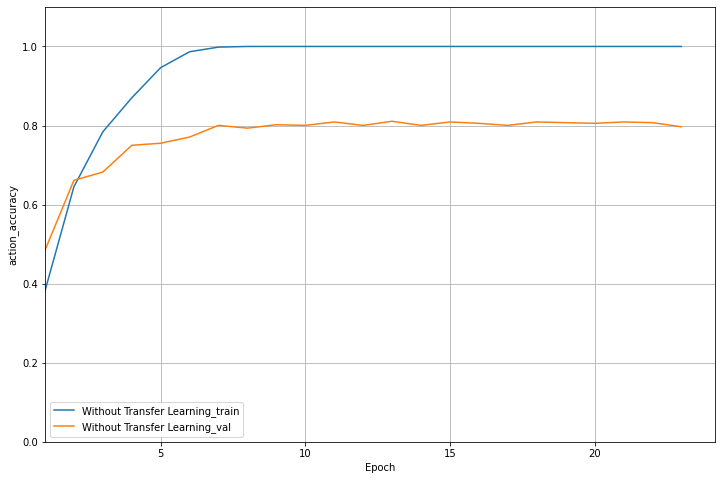

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_accuracy')

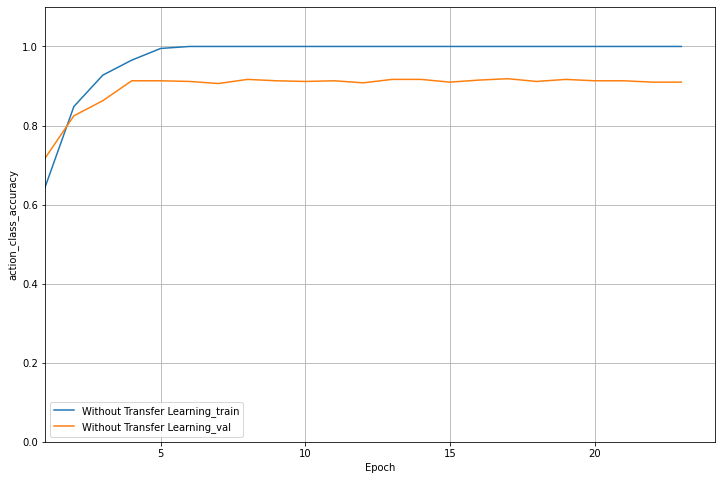

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_class_accuracy')

###Performance of MobileNetV2 without transfer learning on test set

In [ ]:
test_generator = DataGenerator(test_data, batch_size=1, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix)

In [ ]:
result_without_transfer_learning = getResult(mobileNet_model1)

Action Test Result 

Accuracy score:  0.8135313531353136
                    precision    recall  f1-score   support

cleaning_the_floor       0.90      0.82      0.86        22
          climbing       0.97      0.95      0.96        39
           cooking       0.77      0.79      0.78        38
cutting_vegetables       0.71      0.56      0.63        18
   feeding_a_horse       0.83      0.95      0.89        37
         gardening       0.83      0.75      0.79        20
           jumping       0.79      0.85      0.81        39
           phoning       0.70      0.59      0.64        32
    playing_guitar       0.97      0.89      0.93        38
    playing_violin       0.83      0.91      0.87        32
     riding_a_bike       1.00      0.89      0.94        38
    riding_a_horse       0.95      0.92      0.94        39
     rowing_a_boat       0.89      0.94      0.91        17
           running       0.74      0.87      0.80        30
 shooting_an_arrow       0.85      0.74   

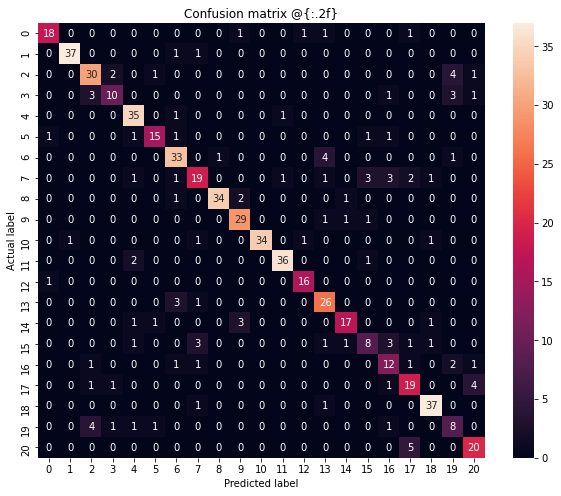

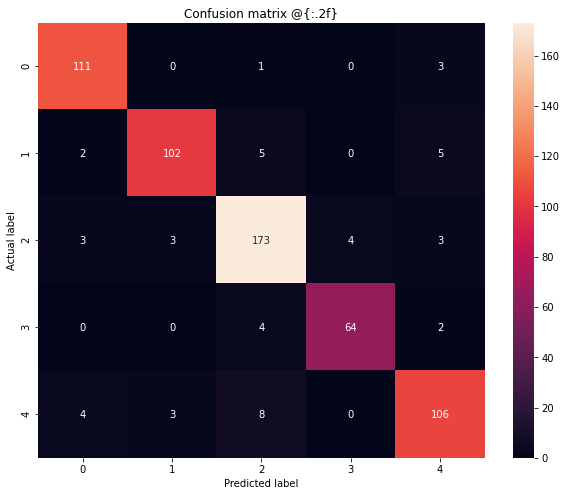

In [ ]:
action_result = result_without_transfer_learning[0]
action_class_result = result_without_transfer_learning[1]

action_result[0] = encoder1.inverse_transform(action_result[0])
action_result[1] = encoder1.inverse_transform(action_result[1])

action_class_result[0] = encoder2.inverse_transform(action_class_result[0])
action_class_result[1] = encoder2.inverse_transform(action_class_result[1])

print("Action Test Result \n")
print("Accuracy score: ", accuracy_score(action_result[0], action_result[1]))
# target=['0','1']
print(classification_report(action_result[0], action_result[1]))
plot_cm(action_result[0], action_result[1])

print("Action Class Test Result \n")
print("Accuracy score: ", accuracy_score(action_class_result[0], action_class_result[1]))
# target=['0','1']
print(classification_report(action_class_result[0], action_class_result[1]))
plot_cm(action_class_result[0], action_class_result[1])

###Conclusion
- We have got decent accuracy on our test set with MobileNetV2 model without transfer learning.
- The accuracy of action for test set is 81.35.
- The accuracy of action_class for test set is 91.74.
- However, the amount of overfitting is significant as the model is giving 100% accuracy on training set.
- The difference between training accuracy and test accuracy is also very high which further confirms high amount of overfitting.
- The model is not generalizing well because of this.
- The macro averaged F1 score is 78 and 92 for action and action_class repectively. This means that our model is predicting properly and not just over-predicting the majority class.
- The model training time is very fast than VGG16.

In [ ]:
mobileNet_model1.save("mobileNet_model1.h5")
!cp -R ./mobileNet_model1.h5 /content/drive/MyDrive/DeepLearning/Assignment1/A1_data/

##MobileNetV2 with Transfer Learning & DropOut

In [ ]:
mobileNet_model2 = create_mobileNet_model(input_shape, n_action, n_action_class, optimizer=optimizer, transfer_learning=True, drop=0.5 )

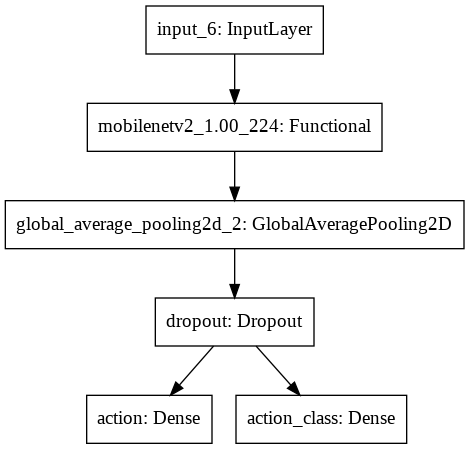

In [ ]:
tf.keras.utils.plot_model(mobileNet_model2)

In [ ]:
mobileNet_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_6[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1280)         0           global_average_pooling2d_2[0][0] 
____________________________________________________________________________________________

In [ ]:
m_histories['With Transfer Learning'] = mobileNet_model2.fit(training_generator, epochs=50, validation_data=validation_generator, callbacks= [early_stopping])

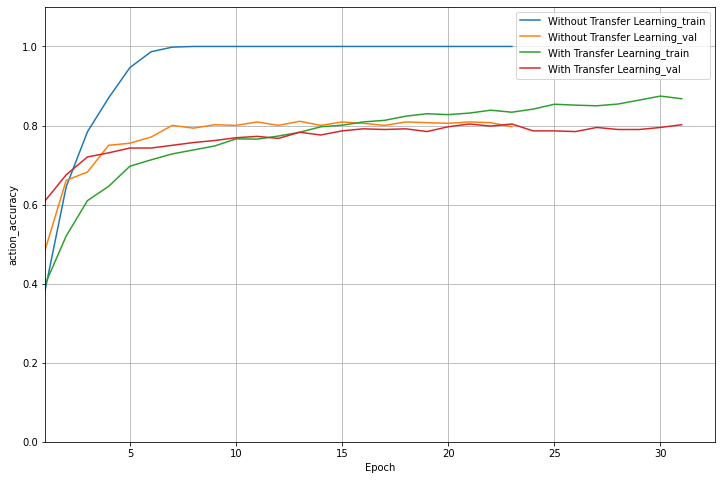

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_accuracy')

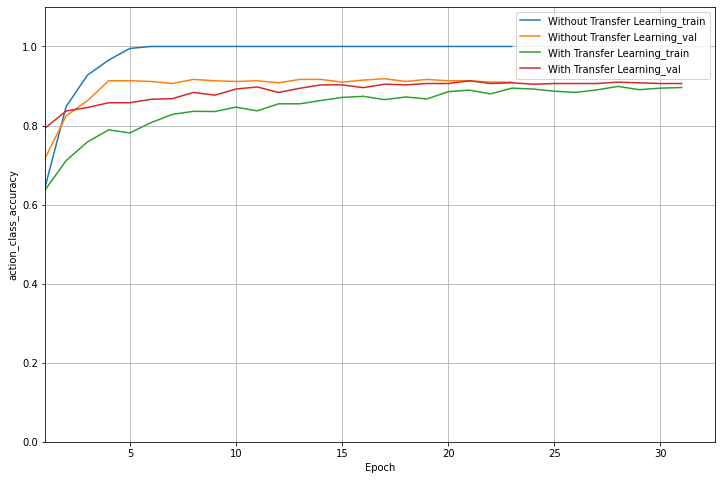

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_class_accuracy')

###Performance of MobileNetV2 with transfer learning on test set

In [ ]:
result_with_transfer_learning = getResult(mobileNet_model2)

Action Test Result 

Accuracy score:  0.801980198019802
                    precision    recall  f1-score   support

cleaning_the_floor       1.00      0.86      0.93        22
          climbing       0.95      0.97      0.96        39
           cooking       0.71      0.71      0.71        38
cutting_vegetables       0.48      0.56      0.51        18
   feeding_a_horse       0.85      0.92      0.88        37
         gardening       0.80      0.80      0.80        20
           jumping       0.85      0.85      0.85        39
           phoning       0.62      0.66      0.64        32
    playing_guitar       0.97      0.84      0.90        38
    playing_violin       0.74      0.88      0.80        32
     riding_a_bike       0.95      0.95      0.95        38
    riding_a_horse       0.95      0.95      0.95        39
     rowing_a_boat       0.94      1.00      0.97        17
           running       0.67      0.80      0.73        30
 shooting_an_arrow       0.83      0.83    

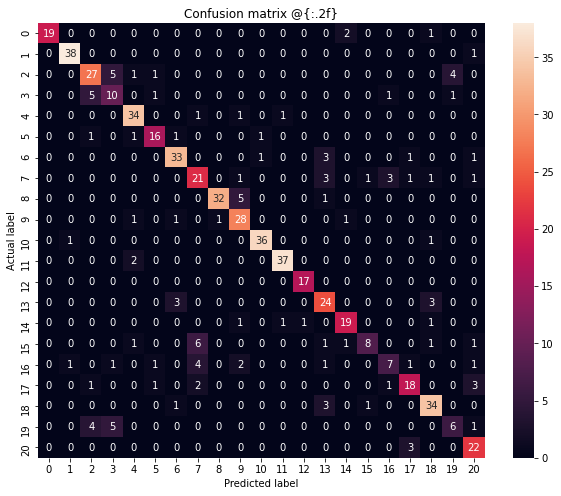

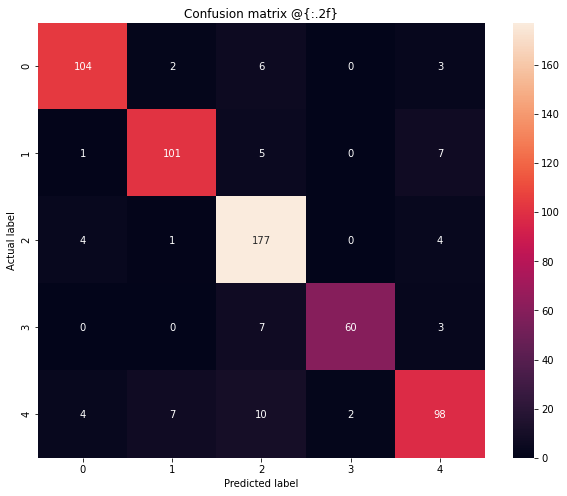

In [ ]:
action_result = result_with_transfer_learning[0]
action_class_result = result_with_transfer_learning[1]

action_result[0] = encoder1.inverse_transform(action_result[0])
action_result[1] = encoder1.inverse_transform(action_result[1])

action_class_result[0] = encoder2.inverse_transform(action_class_result[0])
action_class_result[1] = encoder2.inverse_transform(action_class_result[1])

print("Action Test Result \n")
print("Accuracy score: ", accuracy_score(action_result[0], action_result[1]))
# target=['0','1']
print(classification_report(action_result[0], action_result[1]))
plot_cm(action_result[0], action_result[1])

print("Action Class Test Result \n")
print("Accuracy score: ", accuracy_score(action_class_result[0], action_class_result[1]))
# target=['0','1']
print(classification_report(action_class_result[0], action_class_result[1]))
plot_cm(action_class_result[0], action_class_result[1])

###Conclusion
- We have got better accuracy on our test set with MobileNetV2 model with transfer learning and dropout.
- The accuracy of action for test set is 80.19.
- The accuracy of action_class for test set is 89.10.
- The amount of overfitting is reduced significantly by adding drop out.
- The difference between training accuracy and test accuracy is low.
- The model is generalizing better.
- The macro averaged F1 score is 77 and 89 for action and action_class repectively. This means that our model is predicting properly and not just over-predicting the majority class.

In [ ]:
mobileNet_model2.save("mobileNet_model2")
!cp -R ./mobileNet_model2 /content/drive/MyDrive/DeepLearning/Assignment1/A1_data

INFO:tensorflow:Assets written to: mobileNet_model2/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



##Fine Tuning MobileNetV2 with dropOut and Augmentation

In [ ]:
data_mean = 0.
data_std = 255.0
prefix='./Images/'

training_generator = DataGenerator(train_data, batch_size=32, data_mean=data_mean, data_std=data_std, Augment=True, data_prefix=prefix)
validation_generator = DataGenerator(val_data, batch_size=32, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix)

In [ ]:
mobileNet_model3 = create_mobileNet_model(input_shape, n_action, n_action_class, optimizer = keras.optimizers.Adam(), fine_tune=2,  transfer_learning=True, drop=0.5)

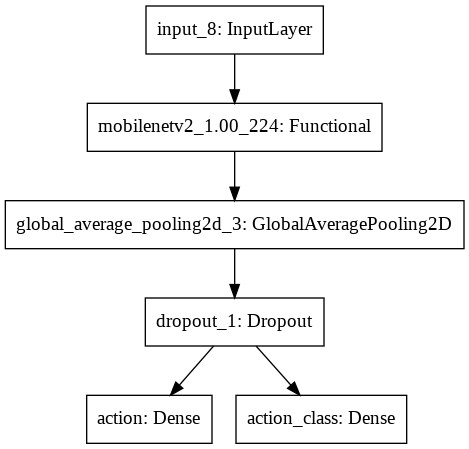

In [ ]:
tf.keras.utils.plot_model(mobileNet_model3)

In [ ]:
mobileNet_model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_8[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1280)         0           global_average_pooling2d_3[0][0] 
____________________________________________________________________________________________

In [ ]:
m_histories['With Fine Tuning'] = mobileNet_model3.fit(training_generator, epochs=50, validation_data=validation_generator, callbacks= [early_stopping])

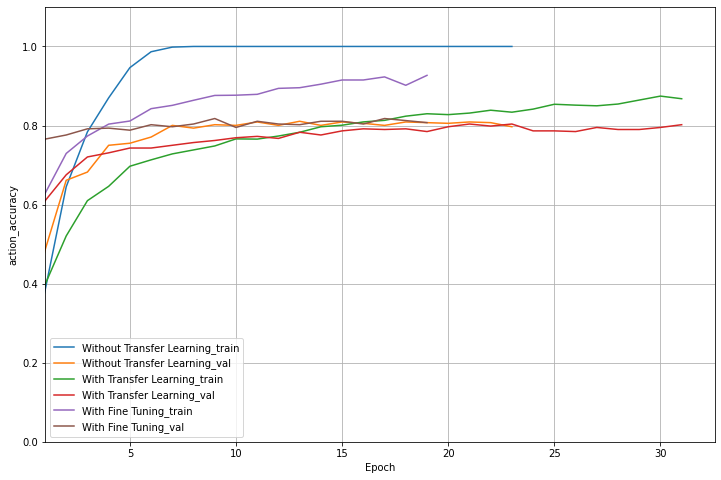

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_accuracy')

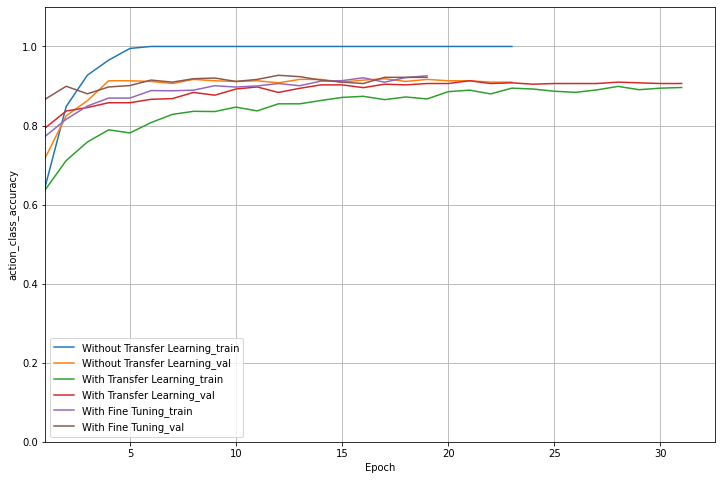

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'action_class_accuracy')

###Performance of MobileNetV2 with fine tuning last 3 layers on test set

In [ ]:
result_with_fine_tuning = getResult(mobileNet_model3)

Action Test Result 

Accuracy score:  0.8234323432343235
                    precision    recall  f1-score   support

cleaning_the_floor       1.00      0.82      0.90        22
          climbing       0.93      0.97      0.95        39
           cooking       0.81      0.68      0.74        38
cutting_vegetables       0.50      0.67      0.57        18
   feeding_a_horse       0.95      0.95      0.95        37
         gardening       0.84      0.80      0.82        20
           jumping       0.77      0.87      0.82        39
           phoning       0.70      0.72      0.71        32
    playing_guitar       0.97      0.87      0.92        38
    playing_violin       0.85      0.88      0.86        32
     riding_a_bike       1.00      0.95      0.97        38
    riding_a_horse       0.97      0.97      0.97        39
     rowing_a_boat       0.94      1.00      0.97        17
           running       0.83      0.80      0.81        30
 shooting_an_arrow       0.90      0.83   

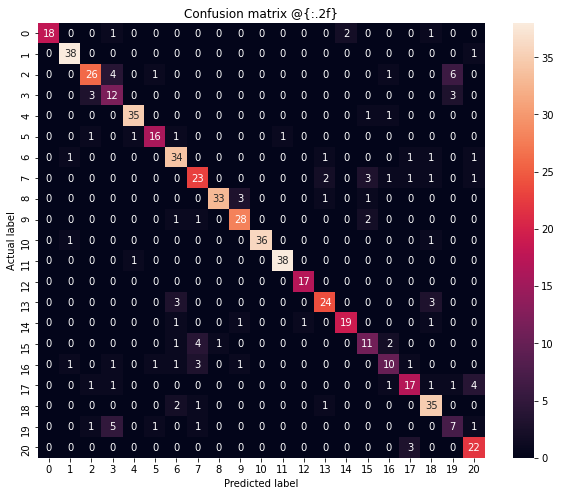

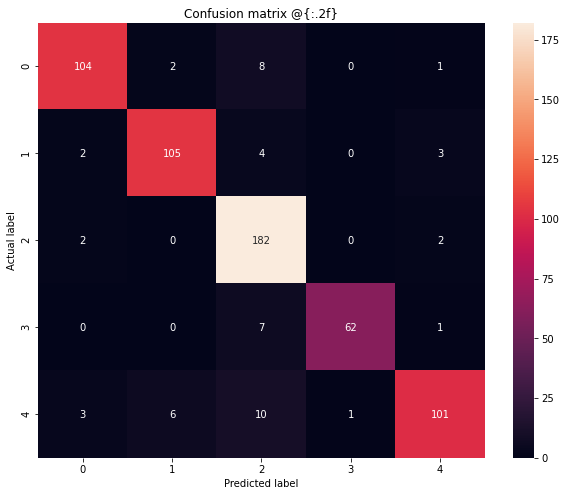

In [ ]:
action_result = result_with_fine_tuning[0]
action_class_result = result_with_fine_tuning[1]

action_result[0] = encoder1.inverse_transform(action_result[0])
action_result[1] = encoder1.inverse_transform(action_result[1])

action_class_result[0] = encoder2.inverse_transform(action_class_result[0])
action_class_result[1] = encoder2.inverse_transform(action_class_result[1])

print("Action Test Result \n")
print("Accuracy score: ", accuracy_score(action_result[0], action_result[1]))
# target=['0','1']
print(classification_report(action_result[0], action_result[1]))
plot_cm(action_result[0], action_result[1])

print("Action Class Test Result \n")
print("Accuracy score: ", accuracy_score(action_class_result[0], action_class_result[1]))
# target=['0','1']
print(classification_report(action_class_result[0], action_class_result[1]))
plot_cm(action_class_result[0], action_class_result[1])

###Conclusion
- We have got better accuracy on our test set with MobileNetV2 model with fine tuning, augmentation and dropout.
- The accuracy of action for test set is 82.34.
- The accuracy of action_class for test set is 91.41.
- The macro averaged F1 score is 80 and 92 for action and action_class repectively. This means that our model is predicting properly and not just over-predicting the majority class.

In [ ]:
# mobileNet_model3.save("mobileNet_model3")
!cp -R ./mobileNet_model3 /content/drive/MyDrive/DeepLearning/Assignment1/A1_data

#Testing fine tuned model on actual test set

In [ ]:
actual_test = pd.read_csv('/content/drive/MyDrive/DeepLearning/Assignment1/A1_data/S40AR_test_data.csv')

In [ ]:
actual_test.head()

,FileName,action_encoded,action_class_encoded
0,Img_1005.jpg,0,0
1,Img_1012.jpg,0,0
2,Img_1014.jpg,0,0
3,Img_1015.jpg,0,0
4,Img_102.jpg,0,0


In [ ]:
actual_test['action_encoded']=0
actual_test['action_class_encoded']=0

In [ ]:
prediction = pd.read_csv('/content/drive/MyDrive/DeepLearning/Assignment1/A1_data/s1234567_predictions.csv')

In [ ]:
prediction.head()

,FileName,action,action_class
0,Img_1005.jpg,shooting_an_arrow,other_activity
1,Img_1012.jpg,shooting_an_arrow,other_activity
2,Img_1014.jpg,shooting_an_arrow,other_activity
3,Img_1015.jpg,shooting_an_arrow,other_activity
4,Img_102.jpg,shooting_an_arrow,other_activity


In [ ]:
actual_test_generator = DataGenerator(actual_test, batch_size=1, data_mean=data_mean, data_std=data_std,shuffle=False, Augment=False, data_prefix=prefix)

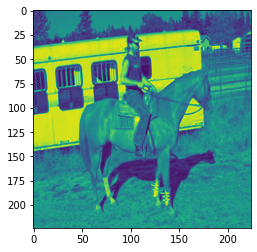

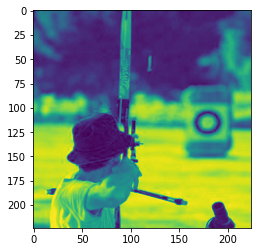

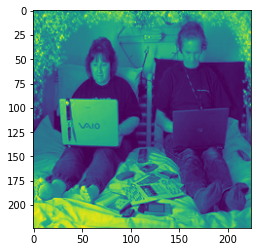

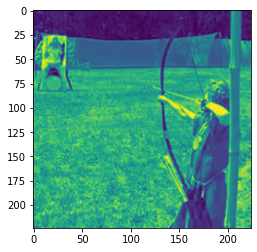

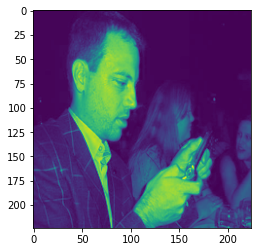

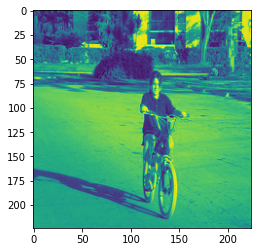

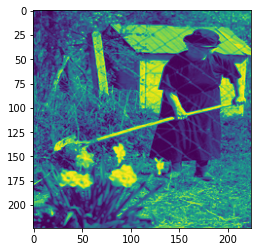

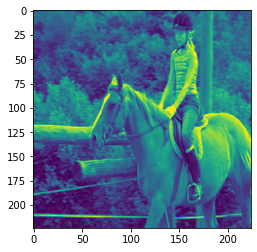

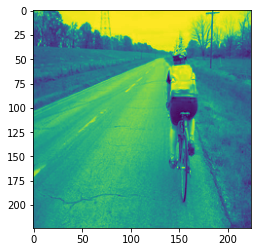

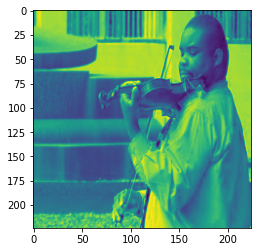

In [ ]:
i=0
for x,y in actual_test_generator.__iter__():
  # if(x.shape == (1, 224, 224, 3)):
  #     continue
  # else:
    # print(x.shape, y[0].shape,y[1].shape)
  if i<10:
    plt.imshow(x[0,:,:,0])
    plt.pause(.1)
    i+=1
  else:
    break

In [ ]:
def getTestResult(models):
  y_hat_all_action_class = list()
  y_hat_all_action = list()
  y_all_action = list()
  y_all_action_class = list()
  filenames = actual_test_generator.image_ids
  N_images = len(filenames)
  batches = 0
  model = models
    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
  for x,y in actual_test_generator:
      y_hat = model.predict(x, verbose=0)
      
      y_hat_action = np.argmax(y_hat[0], axis = 1)
      # print(y_hat_action)
      # y_action = np.argmax(y[0], axis = 1)
      # print(y_action)
      y_hat_all_action = y_hat_all_action + y_hat_action.tolist()
      # y_all_action = y_all_action + y_action.tolist()

      y_hat_action_class = np.argmax(y_hat[1], axis = 1)
      # y_action_class = np.argmax(y[1], axis = 1)
      y_hat_all_action_class = y_hat_all_action_class + y_hat_action_class.tolist()
      # y_all_action_class = y_all_action_class + y_action_class.tolist()

      batches += 1
      if batches >= N_images / 1:
            # we need to break the loop by hand because
            # the generator loops indefinitely
          break

  result = [[y_all_action,y_hat_all_action],[y_all_action_class,y_hat_all_action_class]]
  return result

In [ ]:
actual_test_result = getTestResult(models= mobileNet_model3)

In [ ]:
action_result = actual_test_result[0]
action_class_result = actual_test_result[1]

# action_result[0] = encoder1.inverse_transform(action_result[0])
action_result[1] = encoder1.inverse_transform(action_result[1])

# action_class_result[0] = encoder2.inverse_transform(action_class_result[0])
action_class_result[1] = encoder2.inverse_transform(action_class_result[1])

In [ ]:
prediction['action']= action_result[1]

In [ ]:
prediction['action_class']= action_class_result[1]

In [ ]:
prediction.head()

,FileName,action,action_class
0,Img_1005.jpg,riding_a_horse,Interacting_with_animal
1,Img_1012.jpg,shooting_an_arrow,other_activity
2,Img_1014.jpg,texting_message,using_comm_device
3,Img_1015.jpg,shooting_an_arrow,other_activity
4,Img_102.jpg,texting_message,using_comm_device


In [ ]:
prediction.to_csv('/content/drive/MyDrive/DeepLearning/Assignment1/prediction1.csv')

# Ultimate Judgement
- MobileNetV2 has performed excellent overall as compared to other models which were trained on this dataset such as ResNet50 and VGG16. The training time was also very fast because of less complexity of the architecture.
- The overfitting was reduced significantly by adding drop out and using transfer learning. The model’s generalization power has improved as the model has been already trained on huge imagenet dataset and dropout randomly drops some of the connections which makes training less complex. The model’s accuracy and F1 has also gone down a bit but stil this model is more generalizable in real world.
- Fine-tuned MobileNetV2 with augmentation has performed the best among all the 3 models as it has the least amount of overfitting and better F1 score compared to other models.
- The amount of data is very low for training a deep learning model. The models accuracy could be further improved if we have more dataset to train on. The model could learn more complex patterns with more amount of data.